In [51]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [52]:
script_dir = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
seed = 0

In [53]:
class Hopfield:
    def __init__(self, size):
        self.size = size
        self.weights = np.zeros((size, size))

    def train_hebb(self, patterns, lr=1.0):
        self.weights = np.zeros((self.size, self.size))

        for pattern in patterns:
            self.weights += lr * np.outer(pattern, pattern)

        np.fill_diagonal(self.weights, 0)
        self.weights /= len(patterns)
    
    
    def train_oja(self, patterns, lr=0.001, epochs=100):
        self.weights = np.random.uniform(-1, 1, (self.size, self.size)) / np.sqrt(self.size)
        np.fill_diagonal(self.weights, 0)
    
        for _ in range(epochs):
            for pattern in patterns:
                y = np.dot(self.weights, pattern)
                self.weights += lr * y * (pattern - y * self.weights)
                np.fill_diagonal(self.weights, 0)
    
    
    def energy(self, state):
        return -0.5 * np.dot(np.dot(state, self.weights), state)

    def update(self, state, num_iterations=100, update_type="sync"):
        state = state.copy()

        for _ in range(num_iterations):
            if update_type == "async":
                for i in np.random.permutation(self.size):
                    activation = np.dot(self.weights[i], state)
                    state[i] = 1 if activation >= 0 else -1
            else:
                activation = np.dot(self.weights, state)
                state = np.where(activation >= 0, 1, -1)

        return state

In [54]:
def shuffle_pattern(pattern, prob):
    noise = np.random.rand(pattern.size) < prob
    noisy_pattern = np.where(noise, -1 * pattern, pattern)
    
    return noisy_pattern

In [55]:
def show_pattern(pattern, size):
    pattern = pattern.copy()
    pattern.shape = size
    plt.imshow(pattern, cmap="gray")
    plt.show()

In [56]:
def pattern_diff(pattern1, pattern2):
    return np.sum(pattern1 != pattern2)

In [57]:
folder_path = 'data'
files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

In [58]:
patterns = pd.read_csv(files[0], header=None).values

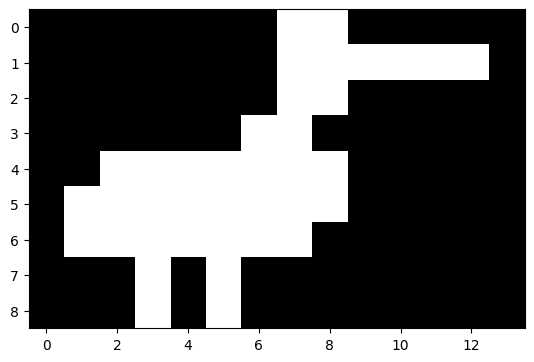

In [59]:
show_pattern(patterns[1], (9, 14))

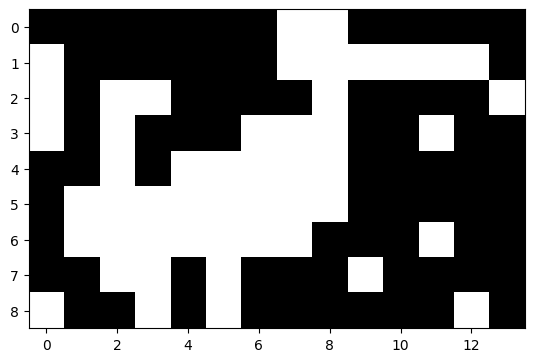

In [60]:
noisy_pattern = shuffle_pattern(patterns[1], 0.1)
show_pattern(noisy_pattern, (9, 14))

In [61]:
hebb_net = Hopfield(len(patterns[0]))
hebb_net.train_hebb(patterns)

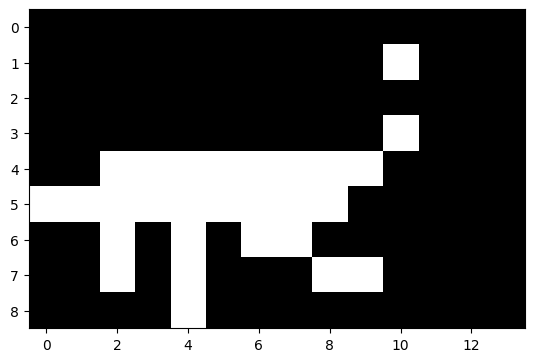

Energy: -2078.6666666666665
Diff: 26


In [62]:
recalled_pattern = hebb_net.update(noisy_pattern, num_iterations=100)
show_pattern(recalled_pattern, (9, 14))
print("Energy:", hebb_net.energy(recalled_pattern))
print("Diff:", pattern_diff(recalled_pattern, patterns[1]))

In [63]:
import re

def extract_dataset_size(input_string):
    match = re.search(r'(\w+)-(\d+x\d+)', input_string)
    if match:
        dataset_size = match.group(2).split('x')
        return int(dataset_size[0]), int(dataset_size[1])
    return None, None

In [64]:
data = []
for file in files:
    name = os.path.basename(file)
    data.append({
        'df': pd.read_csv(file, header=None).values,
        'name': name,
        'size': extract_dataset_size(name)
    })

In [ ]:
shuffle_chance = 0.1
for dataset in data:
    print(dataset['name'], dataset['size'])
    size = dataset['size'][0] * dataset['size'][1]
    hebb_net = Hopfield(size)
    hebb_net.train_hebb(dataset['df'])
    oja_net = Hopfield(size)
    oja_net.train_oja(dataset['df'])

    hebb_total_diff = 0
    hebb_correct = 0
    oja_total_diff = 0
    oja_correct = 0
    for pattern in dataset['df']:
        noisy_pattern = shuffle_pattern(pattern, shuffle_chance)
        recalled_pattern = hebb_net.update(noisy_pattern, num_iterations=100)
        diff = pattern_diff(recalled_pattern, pattern)
        if diff == 0:
            hebb_correct += 1
        hebb_total_diff += diff

        recalled_pattern = oja_net.update(noisy_pattern, num_iterations=1000)
        diff = pattern_diff(recalled_pattern, pattern)
        if diff == 0:
            oja_correct += 1
        oja_total_diff += diff
    print('Average diff (Hebb):', f"{hebb_total_diff / len(dataset['df']) / size:.3f}")
    print('Correct (Hebb):', f"{hebb_correct / len(dataset['df']):.3f}")
    print('Average diff (Oja):', f"{oja_total_diff / len(dataset['df']) / size:.3f}")
    print('Correct (Oja):', f"{oja_correct / len(dataset['df']):.3f}")
    print('\n')

animals-14x9.csv (14, 9)
Average diff (Hebb): 0.136
Correct (Hebb): 0.333
Average diff (Oja): 0.311
Correct (Oja): 0.000


large-25x25.csv (25, 25)
Average diff (Hebb): 0.008
Correct (Hebb): 0.833
Average diff (Oja): 0.316
Correct (Oja): 0.000


large-25x25.plus.csv (25, 25)
Average diff (Hebb): 0.265
Correct (Hebb): 0.067
Average diff (Oja): 0.300
Correct (Oja): 0.000


large-25x50.csv (25, 50)


# Cat dataset (large)

In [ ]:
from PIL import Image
import numpy as np
import os

def convert_images_to_bitmaps(directory_path, target_size):
    result = []
    
    for file_name in os.listdir(directory_path):
        if file_name.endswith(".jpg"):
            image_path = os.path.join(directory_path, file_name)
            
            img = Image.open(image_path)
            img_resized = img.resize(target_size)
            
            img_gray = img_resized.convert("L")
            
            img_array = np.array(img_gray)
            
            img_bitmap = np.where(img_array > 100, 1, -1)
            img_bitmap = img_bitmap.flatten()
            
            result.append(img_bitmap)
    
    return result

In [ ]:
directory_path = "data/cats"
target_size = (300, 300)  # Set your desired size here

bitmaps = convert_images_to_bitmaps(directory_path, target_size)

In [ ]:
bitmaps[0].shape

(90000,)

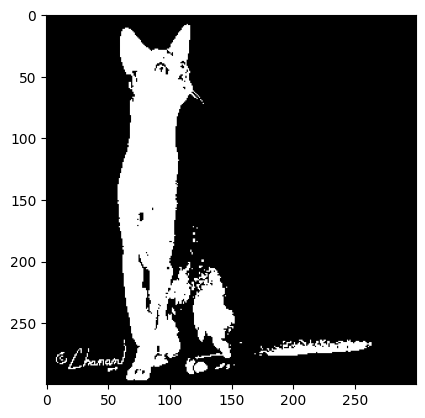

In [ ]:
show_pattern(bitmaps[2], (300, 300))

In [ ]:
# This crashes due to insufficient memory

# shuffle_chance = 0.1
# size = 300 * 300
# hebb_net = Hopfield(size)
# hebb_net.train_hebb(bitmaps)

# hebb_total_diff = 0
# hebb_correct = 0
# for pattern in bitmaps:
#     noisy_pattern = shuffle_pattern(pattern, shuffle_chance)
#     recalled_pattern = hebb_net.update(noisy_pattern, num_iterations=100)
#     diff = pattern_diff(recalled_pattern, pattern)
#     if diff == 0:
#         hebb_correct += 1
#     hebb_total_diff += diff

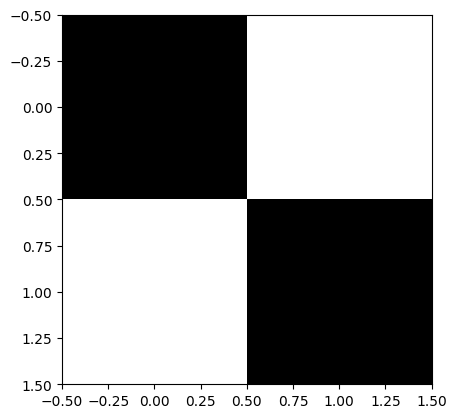

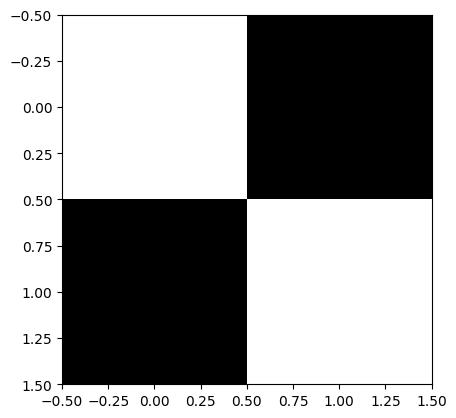

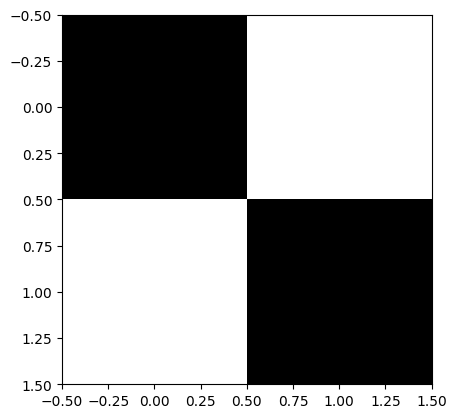

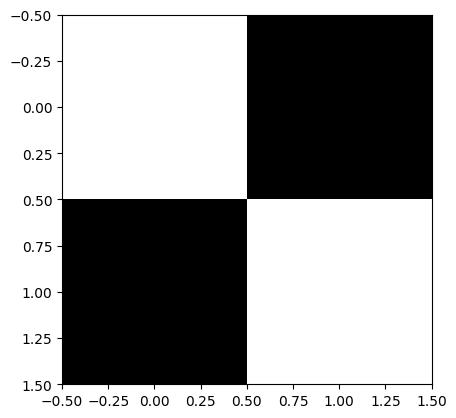

In [ ]:
pattern1 = np.array([1, -1, 1, -1])
pattern2 = -pattern1
initial_state = np.array([1, -1, -1, 1])

net = Hopfield(4)
net.train_hebb([pattern1, pattern2])
show_pattern(net.update(initial_state, num_iterations=1), (2, 2))
show_pattern(net.update(initial_state, num_iterations=2), (2, 2))
show_pattern(net.update(initial_state, num_iterations=3), (2, 2))
show_pattern(net.update(initial_state, num_iterations=4), (2, 2))

# As many patterns as possible

In [ ]:
from scipy.linalg import hadamard
pattern_len = 25
max_patterns = 3

In [ ]:
H = hadamard(32) # has to be power of 2
H = H[:max_patterns, :pattern_len]
H.shape

(3, 25)

In [ ]:
shuffle_chance = 0.1
net = Hopfield(25)
net.train_hebb(H)

total_diff = 0
correct = 0
for i in range(100):
    for pattern in H:
        noisy_pattern = shuffle_pattern(pattern, shuffle_chance)
        recalled_pattern = net.update(noisy_pattern, num_iterations=100)
        diff = pattern_diff(recalled_pattern, pattern)
        if diff == 0:
            correct += 1
        total_diff += diff
print(f'Percentage of correctly recalled patterns shuffle change = {shuffle_chance}: ', correct / len(H) / 100)

Percentage of correctly recalled patterns shuffle change = 0.1:  1.0


# Similar vs diverse patterns

In [ ]:
def generate_similar_patterns(size, num_patterns, noise_level=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    base_pattern = np.random.choice([-1, 1], size=size)
    patterns = []
    for _ in range(num_patterns):
        noisy_pattern = base_pattern.copy()
        num_noisy = int(size * noise_level)
        noisy_indices = np.random.choice(size, num_noisy, replace=False)
        noisy_pattern[noisy_indices] *= -1
        patterns.append(noisy_pattern)
    return np.array(patterns)

def generate_diverse_patterns(size, num_patterns, seed=None):
    if seed is not None:
        np.random.seed(seed)
    return np.random.choice([-1, 1], size=(num_patterns, size))

def test_sim_vs_div(size, num_patterns, noise_level=0.1, seed=None):
    similar_patterns = generate_similar_patterns(size, num_patterns, noise_level, seed)
    diverse_patterns = generate_diverse_patterns(size, num_patterns, seed)

    def evaluate(network, patterns, method_name):
        correct_count = 0
        for pattern in patterns:
            noisy_pattern = pattern.copy()
            num_noisy = int(size * 0.2)
            noisy_indices = np.random.choice(size, num_noisy, replace=False)
            noisy_pattern[noisy_indices] *= -1
            recalled_pattern = network.update(noisy_pattern)
            if np.array_equal(recalled_pattern, pattern):
                correct_count += 1
        accuracy = correct_count / len(patterns)
        print(f"{method_name} accuracy: {accuracy:.2f}")
        return accuracy

    # Train and test for similar patterns
    hebb_net_similar = Hopfield(size)
    oja_net_similar = Hopfield(size)

    hebb_net_similar.train_hebb(similar_patterns)
    oja_net_similar.train_oja(similar_patterns)

    print("Similar Patterns:")
    evaluate(hebb_net_similar, similar_patterns, "Hebb")
    evaluate(oja_net_similar, similar_patterns, "Oja")

    # Train and test for diverse patterns
    hebb_net_diverse = Hopfield(size)
    oja_net_diverse = Hopfield(size)

    hebb_net_diverse.train_hebb(diverse_patterns)
    oja_net_diverse.train_oja(diverse_patterns)

    print("Diverse Patterns:")
    evaluate(hebb_net_diverse, diverse_patterns, "Hebb")
    evaluate(oja_net_diverse, diverse_patterns, "Oja")

# Example test with seed
test_sim_vs_div(size=100, num_patterns=10, noise_level=0.2, seed=42)

Similar Patterns:
Hebb accuracy: 0.00
Oja accuracy: 0.00
Diverse Patterns:
Hebb accuracy: 0.90
Oja accuracy: 0.00
